In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import glob
from datetime import datetime, timedelta
import os
from skimage import io
from skimage import transform
from skimage.filters import  gaussian
from skimage.morphology import disk, remove_small_holes, binary_erosion
from skimage.color import rgb2hsv, hsv2rgb

from sklearn.linear_model import LogisticRegression

# Orthorectification

Bed photos were taken obliquely and then orthorectified using known reference points. For example:

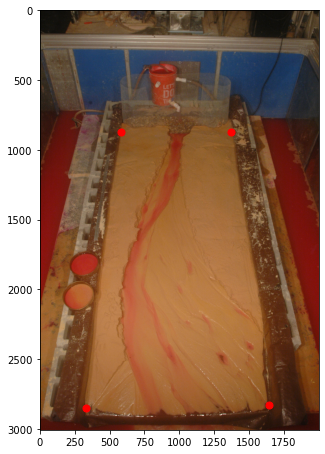

In [2]:
i = 1

flist = glob.glob(os.path.join('data', 'photo_example', '*.jpg'))
raw_image = io.imread(flist[i])

# Show image
fig, ax = plt.subplots(figsize=(5, 10))
ax.imshow(raw_image)

dst = np.array([[585, 870], [1370, 870], [1640, 2830], [330, 2850]])
ax.scatter(dst[:, 0], dst[:,1], c='r', s=50)

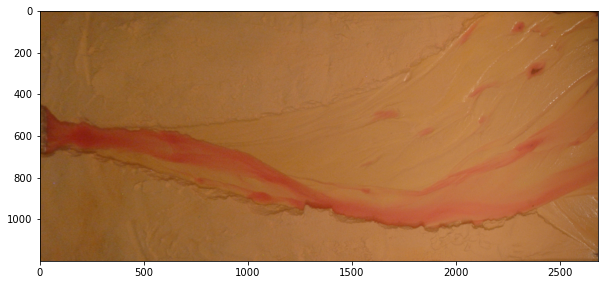

In [3]:
def rectify(image):
    
    # destination coordinates
    dst = np.array([[0, 1200], [0, 0], [2680, 0], [2680, 1200]])
    
    # source coordinates
    src = np.array([[585, 870], [1370, 870], [1640, 2830], [330, 2850]])

    # define transform
    tform3 = transform.ProjectiveTransform()
    tform3.estimate(dst, src)
    
    # execute
    rectim = transform.warp(image, tform3, output_shape=(1200, 2680))
    return rectim

rectified_image = rectify(raw_image)
imshape = rectified_image.shape

# Show image
fig, ax = plt.subplots(figsize=(10, 5))
ax.imshow(rectified_image)

# Calculate depth proxy

Flow depth is estimated from pixel color valuesl. First, we correct for differences in lighting across the image by converting to HSV, set V to a fixed value, then convert back to RGB.

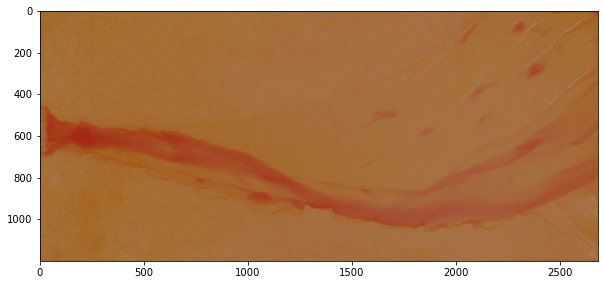

In [4]:
def correct(image_in):
    
    hsv = rgb2hsv(image_in) # calculate HSV from RGB
    hsv[:,:,2] = 0.65 # set v to a constant value

    # convert back to RGB
    return hsv2rgb(hsv)

corrected_image = correct(rectified_image)

fig, ax = plt.subplots(figsize=(10, 5))
ax.imshow(corrected_image)

Note that $V = max(R, G, B)$. Because the red band is brightest in all images, color differences are reduced to blue and green bands.

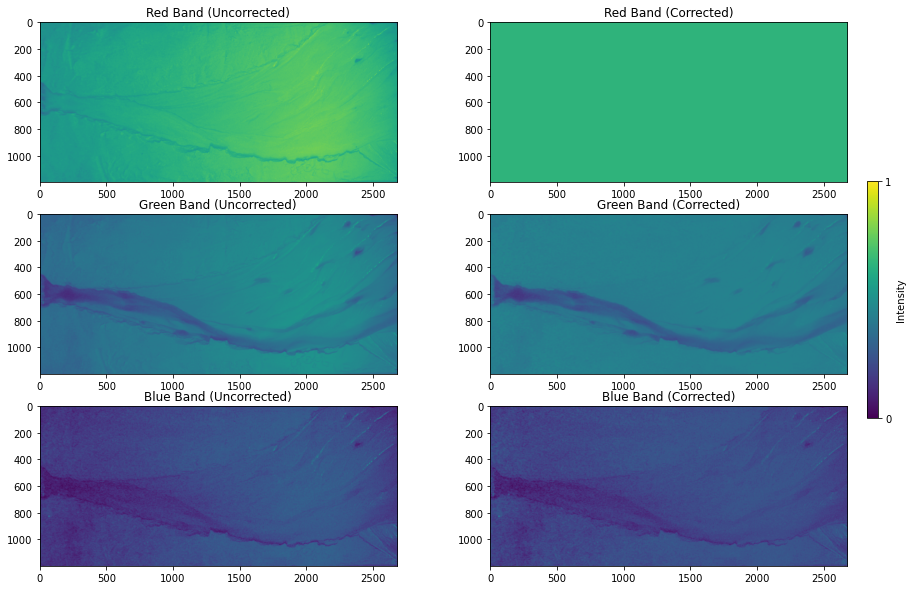

In [5]:
fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(15, 10))

plt.subplots_adjust(right=0.89)
cax = plt.axes([0.9, 0.33, 0.01, 0.33])

# make colorbar
cmap = mpl.cm.viridis
norm = mpl.colors.Normalize(vmin=0, vmax=1)
cb1 = mpl.colorbar.ColorbarBase(cax, cmap=cmap, norm=norm)
cb1.set_label('Intensity')
cb1.set_ticks([0, 1])
cb1.set_ticklabels([0,1])

ax[0,0].set_title('Red Band (Uncorrected)')
ax[0,0].imshow(rectified_image[:,:,0], vmin=0, vmax=1)

ax[0,1].set_title('Red Band (Corrected)')
ax[0,1].imshow(corrected_image[:,:,0], vmin=0, vmax=1)

ax[1,0].set_title('Green Band (Uncorrected)')
ax[1,0].imshow(rectified_image[:,:,1], vmin=0, vmax=1)

ax[1,1].set_title('Green Band (Corrected)')
ax[1,1].imshow(corrected_image[:,:,1], vmin=0, vmax=1)

ax[2,0].set_title('Blue Band (Uncorrected)')
ax[2,0].imshow(rectified_image[:,:,2], vmin=0, vmax=1)

ax[2,1].set_title('Blue Band (Corrected)')
ax[2,1].imshow(corrected_image[:,:,2], vmin=0, vmax=1)

The channel identification model is trained using four manually digitized channel masks. The figure below shows transformed, corrected images and associated channel masks used to create the training dataset.

Text(0.5, 1.0, 'Mapped Channel 3')

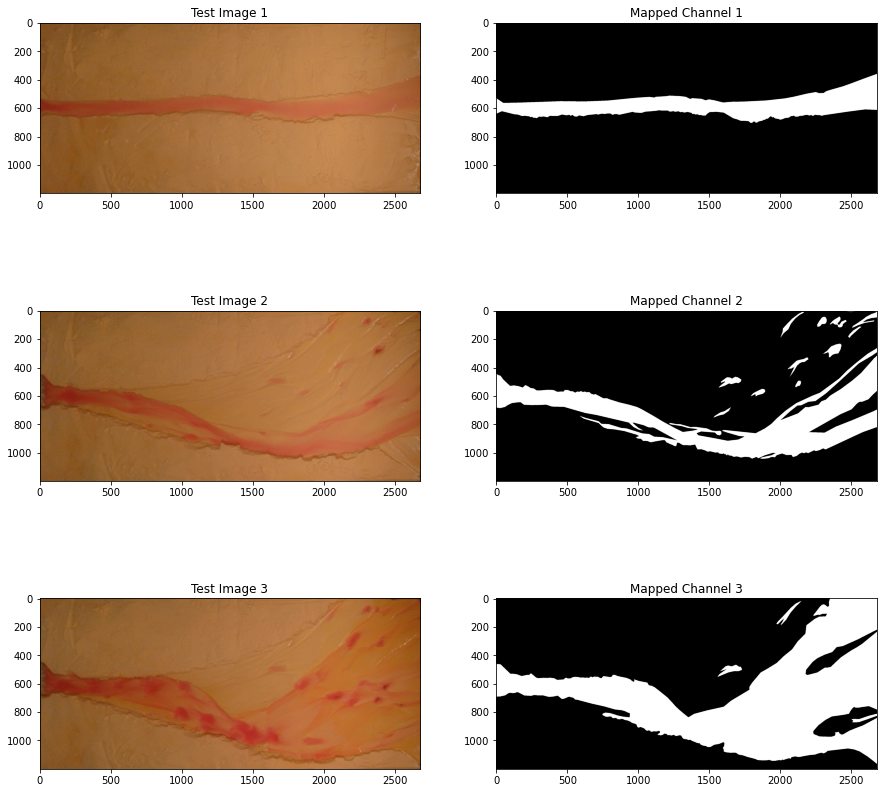

In [6]:
masklist = glob.glob(os.path.join('data','photo_example', 'mask*.png'))

fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(15,15))

for i in range(3):
    rectim = rectify(io.imread(flist[i]))
    mask = ~(io.imread(masklist[i])/255)[:,:,0].astype(bool)
    ax[i,0].imshow(rectim)
    ax[i,1].imshow(mask, cmap='Greys_r')
    
ax[0,0].set_title('Test Image 1')
ax[1,0].set_title('Test Image 2')
ax[2,0].set_title('Test Image 3')

ax[0,1].set_title('Mapped Channel 1')
ax[1,1].set_title('Mapped Channel 2')
ax[2,1].set_title('Mapped Channel 3')

## Perform logistic regression on the training data

We fit a logistic regression model to predict whether individual pixels are part of the channel. Specifically, we consider a linear model for the log-odds (logit) that a specific pixel is part of the channel as a function of the value-corrected blue and green pixel values, $B$ and $G$:

$$
\mathrm{logit}(p) = \beta_0 + \beta_1 G + \beta_2 B.
$$

where $p$ is the probability that a specific pixel is in the channel. Note that $\mathrm{logit}(p)$ and $p$ are related by:

$$
\textrm{logit}(p) = \textrm{ln}\left(\frac{p}{1-p}\right)
$$

To identify the channel, we predict $p$ using this model and then classify pixels where $p>0.5$ as part of the channel. The condition $p=0.5$ is equivalent to $\textrm{logit}(p)=0$.

In [7]:
# get vectors of predictor and response variables
garr = np.empty((rectim.shape[0], rectim.shape[1], len(flist)))
barr = np.empty_like(garr)
maskarr = np.empty_like(garr)

for i in range(len(flist)): 
    # load masks
    maskarr[:,:,i] = ~(io.imread(masklist[i])/255)[:,:,0].astype(bool)
    # load images
    im = correct(rectify(io.imread(flist[i])))
    garr[:,:,i] = im[:,:,1]
    barr[:,:,i] = im[:,:,2]

# format data for fitting
gvec = garr.reshape(garr.size) # Green
bvec = barr.reshape(barr.size) # Blue
maskvec = maskarr.reshape(maskarr.size)
X = np.vstack([gvec, bvec]).T
y = maskvec

# Fit the model
model = LogisticRegression(solver='liblinear', random_state=0).fit(X, y)

# get model parameters for plotting
beta_0 = model.intercept_[0]
beta_1, beta_2 = model.coef_[0]
b = -beta_0/beta_2
m = -beta_1/beta_2

The approach finds the maximum likelihood estimates of $\beta$ parameters. In effect, this minimizes the number of incorrect predictions in the training dataset. Becuase there are more observations of dry pixels than wet pixels, this leads to a predictor that is biased towards correctly identifying dry pixels. It is possible to account for this effect by adjusting the threshold value of $p$ to match their relative occurrence in the dataset.

In [8]:
# rescale classifier by relative sample size
p_wet = np.sum(maskvec==1)/len(maskvec)
logit_pwet = np.log(p_wet/(1-p_wet))

# get probability of wetness vs actual wetness for comparison with data
logit = beta_0 + beta_1 * gvec + beta_2 * bvec 
logit_corrected = logit-logit_pwet
p_x = 1/(1+np.exp(-logit))

# For plotting:
b_rescaled = (logit_pwet - beta_0) / beta_2

# Print coefficients
print(beta_0 - logit_pwet)
print(beta_1)
print(beta_2)

43.827113606793596
-122.62441067379115
26.975860048813267


### Visualize the uncorrected and corrected linear classifier

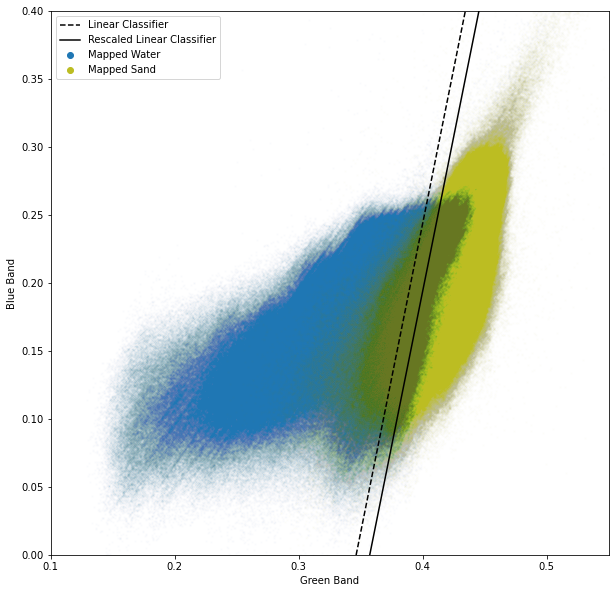

In [9]:
fig, ax = plt.subplots(figsize=(10, 10))

ax.scatter(gvec[maskvec.astype(bool)], bvec[maskvec.astype(bool)], color=sns.color_palette()[0], s=2, alpha=0.01)
ax.scatter(gvec[~(maskvec.astype(bool))], bvec[~(maskvec.astype(bool))], color=sns.color_palette()[8], s=2, alpha=0.01)

xls = np.linspace(0, 0.6)
yls1 = m * xls + b
yls2 = m * xls + b_rescaled
ax.plot(xls, yls1, 'k--', label= 'Linear Classifier')
ax.plot(xls, yls2, 'k', label = 'Rescaled Linear Classifier')

ax.plot(0, 0, lw=0, marker='o', color=sns.color_palette()[0], label='Mapped Water')
ax.plot(0, 0, lw=0, marker='o', color=sns.color_palette()[8], label='Mapped Sand')

ax.legend()

ax.set_xlim(0.1, 0.55)
ax.set_ylim(0, 0.4)

ax.set_xlabel('Green Band')
ax.set_ylabel('Blue Band')

plt.show()

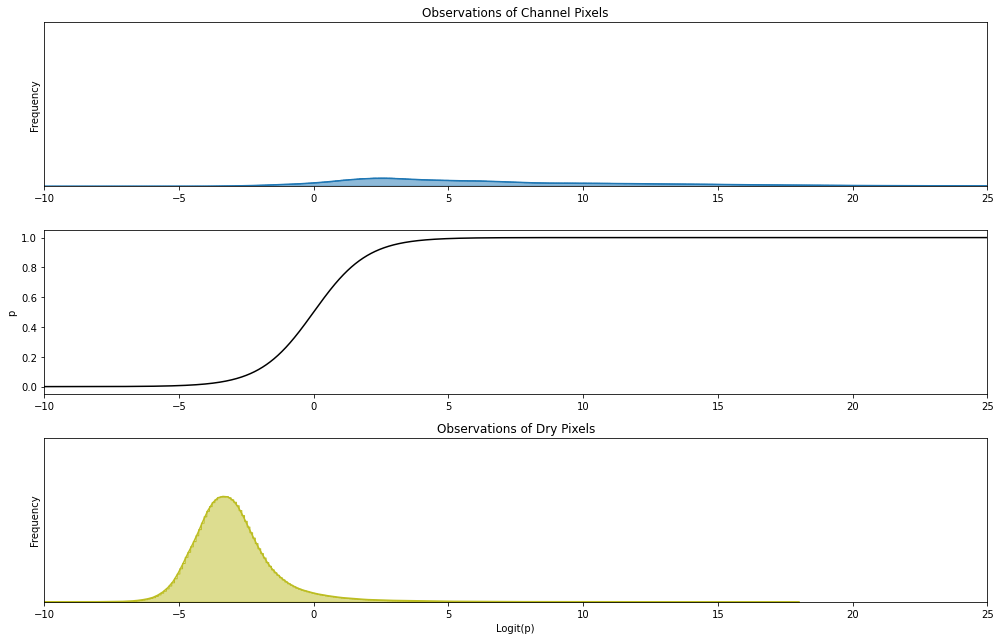

In [10]:
fig, ax = plt.subplots(nrows=3, figsize=(14,9))
sns.histplot(logit_corrected[maskvec==1], kde=True, stat='count', ax=ax[0], color=sns.color_palette()[0], 
             binwidth=0.1, element='step')
sns.histplot(logit_corrected[maskvec==0], kde=True, stat='count', ax=ax[2], color=sns.color_palette()[8], 
             binwidth=0.1, element='step')

logitvec = np.linspace(-25, 25, 10000)
px = 1/(1+np.exp(-logitvec))

ax[1].plot(logitvec, px, c='k')

ax[0].set_xlim(-10, 25)
ax[1].set_xlim(-10, 25)
ax[2].set_xlim(-10, 25)

ax[0].set_title('Observations of Channel Pixels')
ax[2].set_title('Observations of Dry Pixels')
ax[2].set_xlabel('Logit(p)')
ax[1].set_ylabel('p')

ax[0].set_ylim(0, 0.4e6)
ax[2].set_ylim(0, 0.4e6)
ax[0].set_yticks([])
ax[2].set_yticks([])
ax[0].set_ylabel('Frequency')
ax[2].set_ylabel('Frequency')

plt.tight_layout()

## Predicted results for the test image (above)

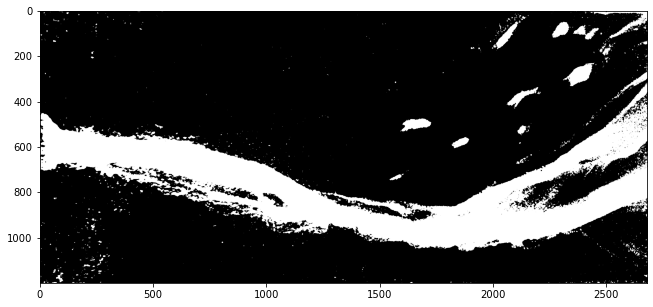

In [19]:
# Predict channel location for test image
logit = (beta_0 - logit_pwet) + beta_1 * corrected_image[:,:,1] + beta_2 * corrected_image[:,:,2]

# Plot results
fig, ax = plt.subplots(figsize=(14,5))
ax.imshow(logit>0, cmap='Greys_r')

Because each pixel is predicted independently, the channel mask is noisy. Spatial smoothing eliminates this issue.

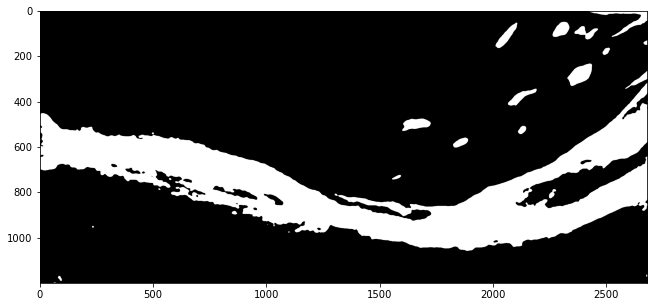

In [12]:
logit = gaussian(logit, 5) # Gaussian blend with a radius of 5 pixels
channel = logit>0

# Plot results
fig, ax = plt.subplots(figsize=(14,5))
ax.imshow(channel, cmap='Greys_r')

Next, we ignore wet regions that are discomnnected from the main channel and perform a binary erosion to correct for widening related to the gaussian blending.

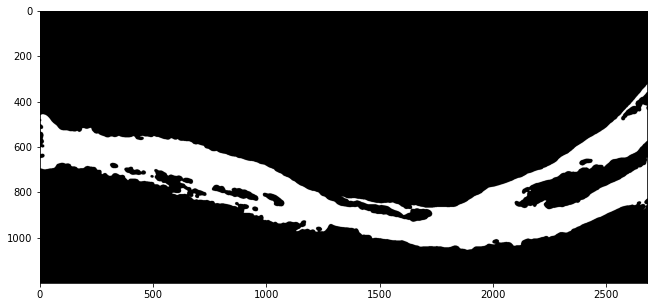

In [13]:
channel = ~remove_small_holes(~channel, area_threshold=20*2688)
channel = binary_erosion(channel, disk(5))

# Plot results
fig, ax = plt.subplots(figsize=(14,5))
ax.imshow(channel, cmap='Greys_r')

Compare with original image:

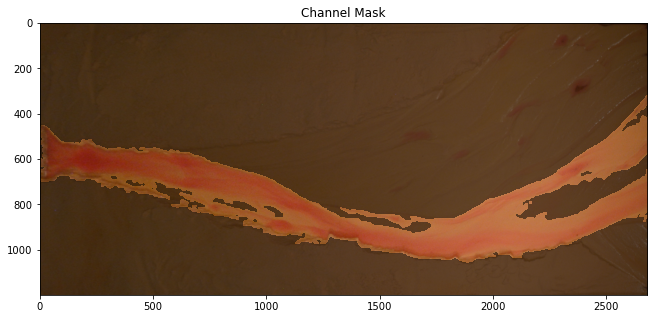

In [14]:
fig, ax = plt.subplots(figsize=(14, 5))
ax.imshow(rectified_image)
ax.set_title('Channel Mask')
masked = np.ma.masked_where(channel, np.ones_like(channel))
ax.imshow(masked, alpha=0.5, cmap='Greys_r')

## Compare performance

In [15]:
channel_mask = np.empty([3, channel.shape[0], channel.shape[1]])
channel_predicted = np.empty([3, channel.shape[0], channel.shape[1]])
W_measured = np.empty([3, channel.shape[1]])
W_predicted = np.empty([3, channel.shape[1]])

for i in range(3):
    # load masks
    mask = ~(io.imread(masklist[i])/255)[:,:,0].astype(bool)
    
    # remove isolated water spots
    channel_mask[i] = ~remove_small_holes(~mask, area_threshold=20*2688)
    
    # calculate width using digitized channel mask
    W_measured[i] = np.sum(channel_mask[i], axis=0)
    
    # run algorithim on image
    im = correct(rectify(io.imread(flist[i])))
    logit = (beta_0 - logit_pwet) + beta_1 * im[:,:,1] + beta_2 * im[:,:,2]
    logit = gaussian(logit, 5)
    predicted = logit>0
    predicted = ~remove_small_holes(~predicted, area_threshold=20*2688)
    channel_predicted[i] = binary_erosion(predicted, disk(5))
    
    # Calculate width using algorithm
    W_predicted[i] = np.sum(channel_predicted[i], axis=0)

    
# Get values from analyzed domain
channel_mask = channel_mask[:,:,100:2600]
channel_predicted = channel_predicted[:,:,100:2600]
W_measured = W_measured[:,100:2600]
W_predicted = W_predicted[:,100:2600]

### Report error statistics

In [16]:
error_factor = (W_predicted/W_measured).ravel()
error_factor[error_factor<1] = 1/(error_factor[error_factor<1])
erf_68 = np.sort(error_factor)[int(0.68 * len(error_factor))]
erf_100 = np.nanmax(error_factor)

px_frac = np.sum(channel_mask==channel_predicted)/channel_predicted.size
w_frac = np.sum(error_factor<2) / error_factor.size

print('{:.01f} percent of pixels are correctly identified'.format(px_frac*100))
print('68 percent of predicted widths lie within a factor of {:.02f} of measured widths'.format(erf_68))
print('100 percent of predicted widths lie within a factor of {:.02f} of measured widths'.format(erf_100))


96.7 percent of pixels are correctly identified
68 percent of predicted widths lie within a factor of 1.20 of measured widths
100 percent of predicted widths lie within a factor of 1.88 of measured widths


In [17]:
# Plot errors

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 0, '$\\mathrm{log}_2(\\mathrm{predicted}/\\mathrm{measured})$')

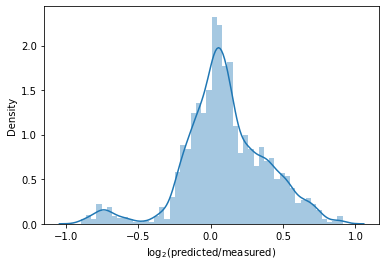

In [18]:
fig, ax = plt.subplots()
sns.distplot(np.log2((W_predicted/W_measured).ravel()))
ax.set_xlabel(r'$\mathrm{log}_2(\mathrm{predicted}/\mathrm{measured})$')